In [1]:
import os
import csv
import math
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchtext.vocab import build_vocab_from_iterator

from sklearn.metrics import roc_auc_score

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune import ExperimentAnalysis

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(1234)

In [3]:
def read_data(path):
    with open(path, 'r') as csvfile:
        train_data = list(csv.reader(csvfile))[1:] # skip col name
        sents, lbls = [], []
        for s, l in train_data:
            sents.append(s)
            lbls.append(l)
    return sents, lbls

def apply_random_masking(seq, num_tokens):
    """
    Mask `num_tokens` as 0 at random positions per sequence. 
    """
    dist = torch.rand(seq.shape)
    m, _ = torch.topk(dist, num_tokens)
    return seq * (dist < m)

def gelu(x):
    """
    Facebook Research implementation of the gelu activation function.
    
    For information: OpenAI GPT's gelu is slightly different
    (and gives slightly different results):
    0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

def regularized_auc(train_auc, dev_auc, threshold=0.0025):
    """
    Returns development AUC if overfitting is below threshold, otherwise 0.
    """
    return dev_auc if (train_auc - dev_auc) < threshold else 0

In [4]:
class CleavageDataset(Dataset):
    def __init__(self, seq, lbl):
        self.seq = seq
        self.lbl = lbl
    
    def __getitem__(self, idx):
        return self.seq[idx], self.lbl[idx]
    
    def __len__(self):
        return len(self.lbl)
    
def collate_train(batch):
    ordered_batch = list(zip(*batch))
    seq = torch.tensor([encode_text(seq) for seq in ordered_batch[0]], dtype=torch.int64)
    seq = apply_random_masking(seq, num_tokens=1)
    lbl = torch.tensor([int(l) for l in ordered_batch[1]], dtype=torch.float)
    return seq, lbl

def collate_dev(batch):
    ordered_batch = list(zip(*batch))
    seq = torch.tensor([encode_text(seq) for seq in ordered_batch[0]], dtype=torch.int64)
    lbl = torch.tensor([int(l) for l in ordered_batch[1]], dtype=torch.float)
    return seq, lbl

In [5]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_size1, rnn_size2, hidden_size, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
        )
        
        self.dropout=nn.Dropout(dropout)
        
        self.lstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=rnn_size1,
            bidirectional=True,
            batch_first=True,
        )

        self.lstm2 = nn.LSTM(
            input_size=2 * rnn_size1,
            hidden_size=rnn_size2,
            bidirectional=True,
            batch_first=True,
        )
        
        self.fc1 = nn.Linear(rnn_size2 * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        
    def forward(self, seq):
        # input shape: (batch_size, seq_len=10)
        embedded = self.dropout(self.embedding(seq))
        
        # input shape: (batch_size, seq_len, embedding_dim)
        out, _ = self.lstm1(embedded)
        
        # input shape: (batch_size, seq_len, 2*rnn_size1)
        out, _ = self.lstm2(out)
        
        # input shape: (batch_size, seq_len, 2*hidden_size)
        pooled, _ = torch.max(out, dim=1)
        
        # input shape: (batch_size, 2*hidden_size)
        out = self.dropout(gelu(self.fc1(pooled)))
        
        # input shape: (batch_size, hidden_size)
        # output shape: (batch_size)
        return self.fc2(out).squeeze()

In [6]:
def process(model, loader, criterion, optim=None):
    epoch_loss, num_correct, total = 0, 0, 0
    preds, lbls = [], []
    
    for seq, lbl in loader:
        seq, lbl = seq.to(device), lbl.to(device)
        
        scores = model(seq)
        loss = criterion(scores, lbl)
        
        if optim is not None:
            optim.zero_grad()
            loss.backward()
            optim.step()
        
        epoch_loss += loss.item()
        num_correct += ((scores > 0) == lbl).sum().item()
        total += seq.shape[0]
        preds.extend(scores.detach().tolist())
        lbls.extend(lbl.detach().tolist())
    return epoch_loss / total, num_correct / total, roc_auc_score(lbls, preds)

In [7]:
# load train and dev data
train_seqs, train_lbl = read_data('../../data/c_train.csv')
dev_seqs, dev_lbl = read_data('../../data/c_val.csv')

# create vocab from train seqs
vocab = build_vocab_from_iterator(train_seqs, specials=['<UNK>'])
vocab.set_default_index(vocab['<UNK>'])
encode_text = lambda x: vocab(list(x))

In [8]:
NUM_EPOCHS = 30
VOCAB_SIZE = len(vocab)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(config, checkpoint_dir=None):
    
    # create train and dev loader
    train_data = CleavageDataset(train_seqs, train_lbl)
    train_loader = DataLoader(train_data, batch_size=512, shuffle=True, collate_fn=collate_train, num_workers=8)

    dev_data = CleavageDataset(dev_seqs, dev_lbl)
    dev_loader = DataLoader(dev_data, batch_size=512, shuffle=True, collate_fn=collate_dev, num_workers=8)
    
    
    model = BiLSTM(
        vocab_size=VOCAB_SIZE,
        embedding_dim=config['embedding_dim'],
        rnn_size1=config['rnn_size1'],
        rnn_size2=config['rnn_size2'],
        hidden_size=config['hidden_size'],
        dropout=config['dropout']
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    criterion = nn.BCEWithLogitsLoss()
    
    # normal train loop
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        train_loss, train_acc, train_auc = process(model, train_loader, criterion, optimizer)
        
        model.eval()
        with torch.no_grad():
            val_loss, val_acc, val_auc = process(model, dev_loader, criterion)
        
        with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
            checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.pt")
            torch.save(model.state_dict(), checkpoint_path)
            
        # metrics that will be reported back to main process
        reg_auc = regularized_auc(train_auc, val_auc)
        
        tune.report(
            train_loss=train_loss,
            dev_loss=val_loss,
            train_acc=train_acc,
            dev_acc=val_acc,
            train_auc=train_auc,
            dev_auc=val_auc,
            reg_auc=reg_auc,
        )
        
        # if model is overfitting, stop the run
        if reg_auc == 0:
            break

In [9]:
class TuneReporter(CLIReporter):
    def __init__(self):
        super().__init__()
        self.num_terminated = 0

    def should_report(self, trials, done=False):
        """Reports only on trial termination events."""
        old_num_terminated = self.num_terminated
        self.num_terminated = len([t for t in trials if t.status == "TERMINATED"])
        return self.num_terminated > old_num_terminated
    
    def report(self, trials, done, *sys_info):
        print(self._progress_str(trials, done, *sys_info))
    
reporter = TuneReporter()
reporter.add_metric_column(metric='train_loss')
reporter.add_metric_column(metric='dev_loss')
reporter.add_metric_column(metric='train_acc')
reporter.add_metric_column(metric='dev_acc')
reporter.add_metric_column(metric='train_auc')
reporter.add_metric_column(metric='dev_auc')
reporter.add_metric_column(metric='reg_auc')

In [10]:
search_space = {
    'embedding_dim': tune.randint(50, 201),
    'rnn_size1': tune.randint(220, 281),
    'rnn_size2': tune.randint(450, 520),
    'hidden_size': tune.randint(120, 181),
    'dropout': tune.quniform(0.45, 0.52, 0.01),
    'lr': tune.choice([5e-5, 1e-4, 3e-4]),
}

In [11]:
path = '../../params/c_term/BiLSTM/'
experiment = 'search'
num_samples = 30

analysis = tune.run(
    train,
    name=experiment,
    config=search_space,
    sync_config=tune.SyncConfig(syncer=None),
    num_samples=num_samples,
    scheduler=ASHAScheduler(
        metric='reg_auc',
        mode='max',
        max_t=25,
        reduction_factor=2,
        grace_period=4
    ),
    progress_reporter=reporter,
    local_dir=path,
    keep_checkpoints_num=None, # keep all checkpoints
    checkpoint_score_attr='reg_auc',
    resume='AUTO',
    resources_per_trial={'cpu': 16, 'gpu': 1},
)

2022-09-13 00:12:13,379	INFO trial_runner.py:510 -- No local checkpoint was found. Ray Tune will now start a new experiment.
2022-09-13 00:12:17,418	WARNING worker.py:1404 -- Warning: The actor ImplicitFunc is very large (21 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Result for train_f4278_00000:
  date: 2022-09-13_00-12-42
  dev_acc: 0.8549559704121169
  dev_auc: 0.8599539170996408
  dev_loss: 0.0006487035507801428
  done: false
  experiment_id: e0cbf5747f1d4bfebf0ab50b958ead9c
  hostname: arch
  iterations_since_restore: 1
  node_ip: 192.168.178.26
  pid: 126164
  reg_auc: 0.8599539170996408
  should_checkpoint: true
  time_since_restore: 23.76518750190735
  time_this_iter_s: 23.76518750190735
  time_total_s: 23.76518750190735
  timestamp: 1663020762
  timesteps_since_restore: 0
  train_acc: 0.8279149102545701
  train_auc: 0.7272859910955798
  train_loss: 0.000810157033372806
  training_iteration: 1
  trial_id: f4278_00000
  warmup_time: 0.0015697479248046875
  
Result for train_f4278_00000:
  date: 2022-09-13_00-13-04
  dev_acc: 0.8583867558999648
  dev_auc: 0.8658633373369828
  dev_loss: 0.0006359892783344695
  done: false
  experiment_id: e0cbf5747f1d4bfebf0ab50b958ead9c
  hostname: arch
  iterations_since_restore: 2
  node_ip: 192.168.178.26


2022-09-13 02:33:53,122	INFO tune.py:747 -- Total run time: 8500.03 seconds (8499.63 seconds for the tuning loop).


Result for train_f4278_00029:
  date: 2022-09-13_02-33-53
  dev_acc: 0.8639520958083833
  dev_auc: 0.8751064043683472
  dev_loss: 0.0006151625299882032
  done: true
  experiment_id: c2dfcaf332a4485f89dae982ddf623aa
  hostname: arch
  iterations_since_restore: 4
  node_ip: 192.168.178.26
  pid: 296259
  reg_auc: 0.8751064043683472
  should_checkpoint: true
  time_since_restore: 92.2470932006836
  time_this_iter_s: 22.819188356399536
  time_total_s: 92.2470932006836
  timestamp: 1663029233
  timesteps_since_restore: 0
  train_acc: 0.854462086595556
  train_auc: 0.852047220499412
  train_loss: 0.0006553527197399174
  training_iteration: 4
  trial_id: f4278_00029
  warmup_time: 0.001775979995727539
  
== Status ==
Current time: 2022-09-13 02:33:53 (running for 02:21:39.63)
Memory usage on this node: 9.6/31.3 GiB
Using AsyncHyperBand: num_stopped=25
Bracket: Iter 16.000: 0.8823495743216672 | Iter 8.000: 0.8803121063238868 | Iter 4.000: 0.8754318273927981
Resources requested: 0/24 CPUs, 0/1 

In [12]:
ana = ExperimentAnalysis(path + experiment)

2022-09-13 02:33:53,198	INFO experiment_analysis.py:757 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


In [13]:
df = ana.dataframe()
cols_needed = [col for col in df.columns if col.startswith('config/')]

In [14]:
df[['train_auc', 'dev_auc', 'reg_auc', 'training_iteration', *cols_needed]].sort_values(by='reg_auc', ascending=False)

,train_auc,dev_auc,reg_auc,training_iteration,config/dropout,config/embedding_dim,config/hidden_size,config/lr,config/rnn_size1,config/rnn_size2
0,0.874430,0.882703,0.882703,25,0.51,111,169,0.00010,269,507
2,0.879424,0.882019,0.882019,16,0.45,171,143,0.00030,262,452
26,0.876672,0.881982,0.881982,25,0.49,198,122,0.00010,246,473
21,0.877974,0.881960,0.881960,25,0.46,171,170,0.00010,254,483
28,0.878873,0.881920,0.881920,16,0.47,169,168,0.00030,233,506
23,0.863896,0.881493,0.881493,25,0.48,97,173,0.00005,239,488
12,0.878521,0.881309,0.881309,25,0.45,169,120,0.00010,259,502
27,0.859582,0.879939,0.879939,8,0.46,118,162,0.00010,247,510
5,0.858426,0.879726,0.879726,8,0.47,97,141,0.00010,269,468
20,0.860784,0.879685,0.879685,8,0.48,193,148,0.00010,254,460


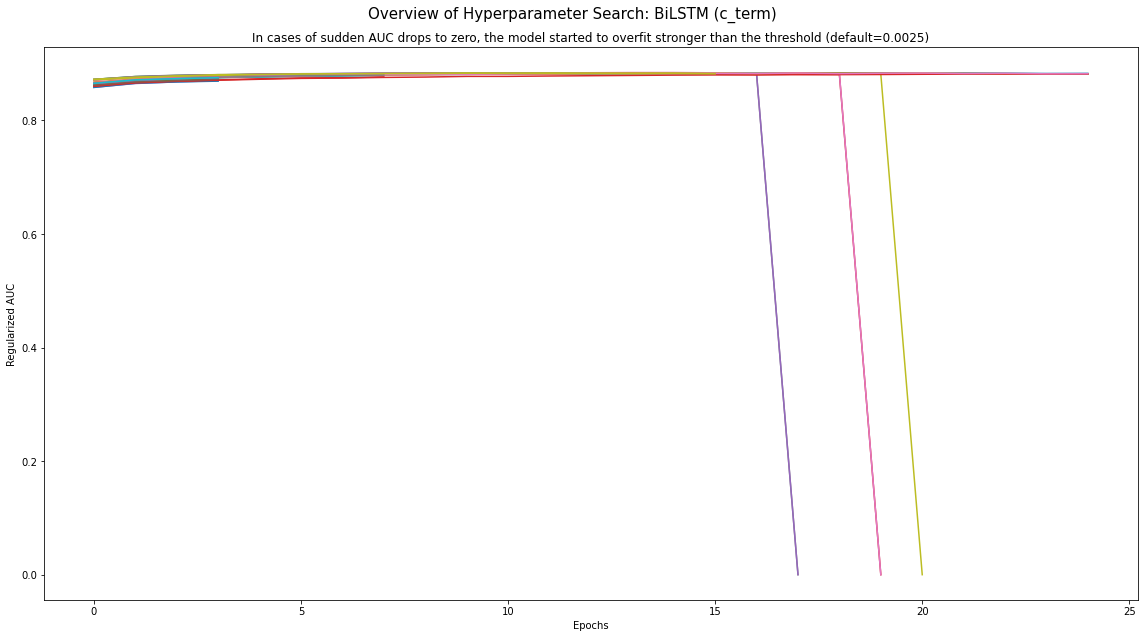

In [15]:
### when the acc suddenly drops to zero, that's when the model started to overfit stronger than the threshold (default=0.0025) 
plt.figure(figsize=(16, 9))
ax = None
for val in ana.trial_dataframes.values():
    ax = val.reg_auc.plot(ax=ax, legend=False)
plt.xlabel('Epochs')
plt.ylabel('Regularized AUC')
plt.suptitle('Overview of Hyperparameter Search: BiLSTM (c_term)', fontsize=15, ha='center')
plt.title("In cases of sudden AUC drops to zero, the model started to overfit stronger than the threshold (default=0.0025)", fontsize=12, ha='center')
plt.tight_layout()
plt.show()